Tomas Korec | +420 739 708 250 | tk.korec@gmail.com | www.korec-finance.cz | https://www.linkedin.com/in/tomas-korec-4419aa214/

In [9]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import requests
from dateutil.relativedelta import relativedelta
from scipy.stats import boxcox
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import statsmodels.api as sm

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, broadcast
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, StringType, ArrayType
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# GIT: git push market_analyses options_debit_spreads

In [14]:
# SETTING UP PYSPARK for faster data processing

os.environ["PYSPARK_PYTHON"] = "/opt/homebrew/bin/python3.11"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/homebrew/bin/python3.11"

spark = (
    SparkSession.builder
    .appName("CallDebitSpread")
    .config("spark.driver.memory", "8g")
    .config("spark.pyspark.python", "/opt/homebrew/bin/python3.11") 
    .config("spark.pyspark.driver.python", "/opt/homebrew/bin/python3.11")  
    .getOrCreate()
    )
spark.sparkContext.setLogLevel("ERROR")

print(spark)

print("Driver Python:", spark.conf.get("spark.pyspark.driver.python"))
print("Worker Python:", spark.conf.get("spark.pyspark.python"))

print("PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))
print("PYSPARK_DRIVER_PYTHON:", os.environ.get("PYSPARK_DRIVER_PYTHON"))

25/04/13 13:44:33 WARN Utils: Your hostname, Tomas-MacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.102 instead (on interface en0)
25/04/13 13:44:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 13:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Driver Python: /opt/homebrew/bin/python3.11
Worker Python: /opt/homebrew/bin/python3.11
PYSPARK_PYTHON: /opt/homebrew/bin/python3.11
PYSPARK_DRIVER_PYTHON: /opt/homebrew/bin/python3.11


MODEL'S RESEARCH OBJECTIVE

The idea of this research is based on the assumption that if 95% confidential boundaries produced by time series predicting model define the area an asset's price will develop in, opening a Call Debit Spread with short call strike price being In-The-Money in this area of 95% probability defines the odds for ....

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^VIX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^TNX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


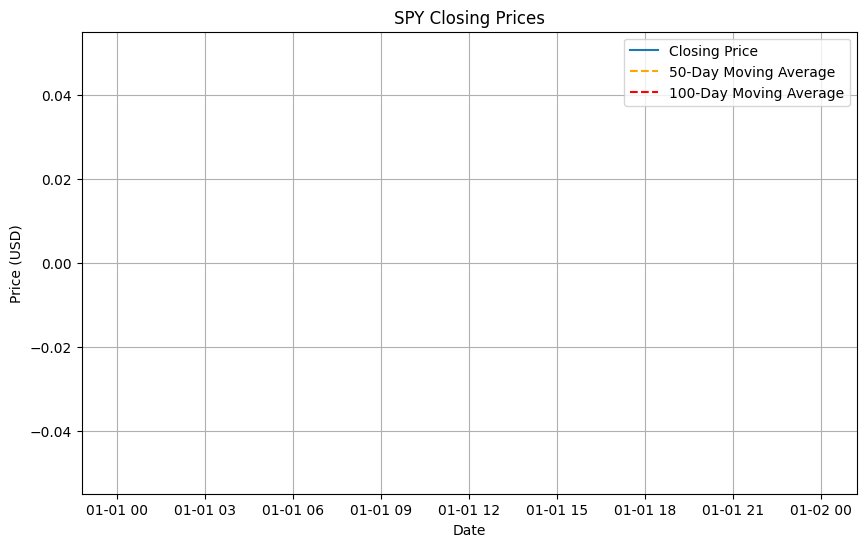

In [12]:
ticker = "SPY"

"""
data = yf.download(
    ticker, # Ticker is chosen based on for what risky asset the analyses is being performed
    start=(datetime.today() - timedelta(days=10*365)).strftime("%Y-%m-%d"),
    end=datetime.today().strftime("%Y-%m-%d"),
    interval="1d"
)
"""


vix_data = yf.download(
    "^VIX",
    start=(datetime.today() - timedelta(days=10*365)).strftime("%Y-%m-%d"),
    end=datetime.today().strftime("%Y-%m-%d"),
    interval="1d"
)

risk_free_rate_data = yf.download(
    "^TNX",
    start=(datetime.today() - timedelta(days=10*365)).strftime("%Y-%m-%d"),
    end=datetime.today().strftime("%Y-%m-%d"),
    interval="1d"
)

# Unify the data form and remove name of an index column
data = pd.DataFrame({
    "Date": data.index,
    "Close": data["Close"][ticker]
})

data.index.name = None

# Add 50 and 100 days Moving Averages to data of risky asset
data["50_day_MA"] = data["Close"].rolling(window=50).mean()
data["100_day_MA"] = data["Close"].rolling(window=100).mean()

# Selected events during which condition on which base the call debit spread would be opened
selected_dates = data[
    (data["50_day_MA"] > data["100_day_MA"]) &
    (data["Close"] > data["100_day_MA"]) &
    (data["Close"] < data["50_day_MA"]) &
    (data.index <= (datetime.today() - timedelta(days=365)))
]

# Visualisation of risky asset's time series, moving averages, and call debit spread events
plt.figure(figsize=(10, 6))
plt.plot(data["Close"], label="Closing Price")
plt.plot(data["50_day_MA"], label="50-Day Moving Average", color="orange", linestyle="--")
plt.plot(data["100_day_MA"], label="100-Day Moving Average", color="red", linestyle="--")
plt.scatter(selected_dates.index, selected_dates["Close"], color="r", marker="o")
plt.title(f"{ticker} Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [23]:
data

,Date,Close,50_day_MA,100_day_MA
2015-04-16,2015-04-16,62.735340,NaN,NaN
2015-04-17,2015-04-17,62.192253,NaN,NaN
2015-04-20,2015-04-20,62.574100,NaN,NaN
2015-04-21,2015-04-21,62.989925,NaN,NaN
2015-04-22,2015-04-22,63.091740,NaN,NaN
...,...,...,...,...
2025-04-07,2025-04-07,134.470001,145.662569,143.432596
2025-04-08,2025-04-08,132.979996,145.382542,143.281853
2025-04-09,2025-04-09,138.759995,145.238636,143.209537
2025-04-10,2025-04-10,134.889999,145.034464,143.102389


APPROXIMATING IMPLIED VOLATILITY

The value of Implied Volatility (IV, i.e., future volatility expectation) is constantly being determined by market forces and it can be found numericaly via Black-Scholes model. However, since I don't have historical option prices either, I can approximate IV using historical realized volatility.

$$
\sigma_{historical} = \sqrt{\frac{252}{N} \sum_{i=1}^{N} (\ln(\frac{S_i}{S_{i-1}}))^2}
$$

where

$N$ = number of trading days in the historical window and 252 days is used for annualization of the volatility $\newline$
$S_i$ = stock price on day i $\newline$
$\sigma_{historical}$ = historical volatility as a proxy for implied volatility

Logarithmic returns measure the percentage change in the stock price between two consecutive periods, e.g., days. Relative change expressed by the fraction is transformed into more symmetric measure via natural logarithm.


.............



BLACK-SCHOLES MODEL

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

Where

$$
d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

In [24]:
def calculate_historical_volatility(historical_volatility_data):
    sum_squared_returns = historical_volatility_data["log_returns_squared"].sum()
    n = historical_volatility_data["log_returns"].count()
    sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
    return round(sigma_historical, 6)

def calculate_call_option_price(s_0, strike, sigma, time_to_exercise, r):
    d1 = (math.log(s_0/strike) + (r + 0.5 * sigma**2) * time_to_exercise) / (sigma * np.sqrt(time_to_exercise))
    d2 = d1 - sigma * np.sqrt(time_to_exercise)
    call_price = s_0 * norm.cdf(d1) - strike * np.exp(-r * time_to_exercise) * norm.cdf(d2)      
    return call_price  

def set_expiration_date(date):
    day_deduction = 0
    while data[data.index == (date + relativedelta(years=1, days=day_deduction))].shape[0] == 0:
        day_deduction -= 1
    expiration_date = (date + relativedelta(years=1, days=day_deduction))
    return expiration_date

MODEL


Improvements decisions – for each tested asset, for prediction's higher accuracy, time series preiction model can be found manually instead of having the ones produced universally by Hyndman and Khandakar algorithm.

In [1]:
class ModelARIMA():

      def __init__(self) -> None:
            pass

      def hyndman_khandakar(self, series):
            auto_model = auto_arima(series)
            #forecast, conf_int = auto_model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
            #conf_int = conf_int[0]
            order = list(auto_model.order)
            seasonal_order = list(auto_model.seasonal_order)
            parameters = []
            parameters.append(order)
            parameters.append(seasonal_order)
            return parameters
      
      def check_stationarity(self, data):
            result = adfuller(data)
            if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
                  return True
            else:
                  return False
        
      def invert_differencing(self, forecast, differencing_count, data):
            reverted = forecast
            for i in range(1, differencing_count + 1):
                  reverted = reverted.cumsum() + data["Close"].iloc[-i]
            return reverted

      def arima_model(self, series, parameters):
            order = tuple(parameters[0])
            seasonal_order = tuple(parameters[1])
            model = sm.tsa.statespace.SARIMAX(series, order=order, seasonal_order=seasonal_order, trend="c")
            res = model.fit(disp=False)
            forecast = res.get_prediction(steps=1)
            expected = forecast.predicted_mean.values[0]
            conf_int = forecast.conf_int(alpha=0.05).values.tolist()[0]
            return expected, conf_int

      def get_parameters(self, data):
            close_p = data["Close"]

            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  is_data_stationary = self.check_stationarity(close_p)

            parameters = self.hyndman_khandakar(close_p)
            return parameters
      
      def model(self, data, parameters):
            data = data.sort_values(by="Date", ascending=True)
            close_p = data["Close"]
            differencing_count = 0
            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  differencing_count += 1
                  is_data_stationary = self.check_stationarity(close_p)

            forecast, conf_int = self.arima_model(close_p, parameters)

            conf_int = np.array(conf_int, ndmin=2)  
            forecast = pd.Series(forecast)

            forecast = self.invert_differencing(forecast, differencing_count, data)
            conf_int[:, 0] = self.invert_differencing(conf_int[:, 0], differencing_count, data)
            conf_int[:, 1] = self.invert_differencing(conf_int[:, 1], differencing_count, data)

            return forecast, conf_int
      

# Set up Model object and get parameters of ARMA model
#model = ModelARIMA()
#parameters = model.get_parameters(data)
#parameters


DEBIT CALL SPREAD

Debit Call Spread is an option strategy when Call option with lower strike price is bought while the Call option on the same asset and same expiration date with higher strike price is written.

– Max loss of a Call Debit Spread is given by the premium paid for the spread: $$\text{Max Loss} = \text{Premium Paid for the Long Call (lower call)} - \text{Premium Received for the Short Call (higher strike)} = \text{Net Premium Paid}$$

– Max profit of a Call Debit Spread is given by the difference between the strike prices minus the net premium paid: $$\text{Max Profit} = \text{(Short Call strike - Long Call strike)} - \text{Net Premium Paid}$$

– Profit/Loss at expiration under the scenario that asset's price at expiration is equal to or higher than strike price of bought call option and lower than strike price of written call option is given by the deduction of bought option strike price from asset's price at expiration minus Net Premium Paid: $$\text{P/L under } K_1 <= S_T < K_2 \text{ scenario } = (S_T - K_1) - \text{Net Premium Paid}$$

Before expiration, beyond options' intrinsic value described above, spread value is influenced by options' extrinsic values – time decay (Theta), implied volatility (Vega), and interest rates (Rho) – as well. The call debit spread value is given by prices of call options it consists of.

..........
..........

PROGRAM FLOW:

selected_dates – considering the 1 year expiration, selected dates are a series of trading days starting today minus 1 year

Iteration through selected_dates. For each selected date, derive ATM strike price from at that time asset's trading price and build an option chain (set of options with various strike prices) containing options with strike prices by 1 USD on both sides, OTM and ITM, from ATM strike price. The last OTM and ITM options are given by 95% confidential boundaries of prediction produced by ARMA model for asset's prices for the last year before selected date. Price of each call option is calculated via Black-Scholes model and proxy of Implied Volatility. All possible Call Debit Spreads are created.

OBJECTIVES:
1. For all Call Debit Spreads existing within the 95% confidential boundaries, calculate probability of P/L at the expiration date (in 1 year).
2. For all Call Debit Spreads existing within the 95% confidential boundaries, calculate probability of achieving 60% of max profit before
   expiration.
3. What Call Debit Spreads – with what strikes – have the highest probability of profit.

SHORTCOMINGS:

Prices of historical options aren't the actual prices as they were at that time. Prices are obtained via Black-Scholes model using historical volatility calculated from asset's prices following after the date for which the proxy of implied volatility is calculated. Even though this
makes the expected volatility accurate (actual volatility is used), it's different from the expectation at that time, so the call options are
misspriced. Moreover, this way, prices of all options in an option chain for one date are calculated using the same proxy of IV, while in reality, implied volatilities differ for various strike prices.
This inaccuracy can be addressed by using actual historical option prices from Alphavantage API.

In [26]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

selected_dates = selected_dates.sort_values(by="Date", ascending=False)
data = data.sort_values(by="Date", ascending=False)
spreads = []

for i in range(0, selected_dates.shape[0]):
    date = selected_dates["Date"].iloc[i]
    
    forecast, confidential_boundary = model.model(data[data["Date"] <= date], parameters)
    atm_strike_price = round(forecast[0])
    # this will be given by the confidential boundaries obtained via time series predicting model
    #strike_list_lower_boundary = round(atm_strike_price - atm_strike_price * 0.05)
    #strike_list_upper_boundary = round(atm_strike_price + atm_strike_price * 0.05)
    strike_list_lower_boundary = round(confidential_boundary[0][0])
    strike_list_upper_boundary = round(confidential_boundary[0][1])
    strike_prices_list = [strike for strike in range(strike_list_lower_boundary, strike_list_upper_boundary + 1)]

    # Historical volatility as a proxy of implied volatility for a particular historical date on which we want to
    # compute option price is calculated on data since that date to presence
    historical_volatility_data = data[(data["Date"] >= date) & (data["Date"] <= date + pd.DateOffset(years=1))].sort_values(by="Date", ascending=True)
    historical_volatility_data["log_returns"] = np.log(historical_volatility_data["Close"] / historical_volatility_data["Close"].shift(1))
    historical_volatility_data["log_returns_squared"] = historical_volatility_data["log_returns"]**2
    sigma_historical = calculate_historical_volatility(historical_volatility_data)
    
    # Create an empty strike price chain – available options for particular strike prices on a particular date
    # At this stage, only strike prices and proxy of implied volatilities are known and expiration date is opened
    strike_price_chain = {}
    strike_price_chain = {
        "strike": strike_prices_list,
        "price": np.full(len(strike_prices_list), None),
        "implied_volatility": np.full(len(strike_prices_list), sigma_historical)
    }

    strike_price_chain = pd.DataFrame(strike_price_chain)

    # Calculating price of options in a strike price chain
    strike_price_chain["price"] = strike_price_chain.apply(
        lambda row: calculate_call_option_price(
            data.loc[date, "Close"],  # Stock price (scalar)
            row["strike"],  # Strike price (scalar)
            row["implied_volatility"],  # Implied volatility (scalar)
            historical_volatility_data.shape[-1] / (252 * 2),  # Time to exercise
            risk_free_rate_data.loc[date, "Close"] / 100  # Risk-free rate adjusted to ratio of 1 as implied volatility
        ),
        axis=1
    )

    # From a strike price chain, set of Call Debit Spread is created and inserted into spreads DataFrame
    for i, long_call in strike_price_chain.iterrows():
        for j, short_call in strike_price_chain.iloc[i+1:].iterrows():
            spread_cost = long_call["price"] - short_call["price"]
            max_profit = (short_call["strike"] - long_call["strike"]) - spread_cost # !!!! This doesn't seem to be correct

            spreads.append({
                "date": date,
                "expiration_date": set_expiration_date(date),
                "long_strike": long_call["strike"],
                "short_strike": short_call["strike"],
                "long_price": long_call["price"],
                "short_price": short_call["price"],
                "spread_cost": spread_cost,
                "max_profit": max_profit,
                "max_loss": spread_cost,
                "expiration_p/l": None,
                "%_profit": None,
                "trading_days": None
            })

            
spreads = pd.DataFrame(spreads)

spreads = spreads[
    (spreads["long_strike"] < spreads["short_strike"]) &
    (spreads["short_strike"] > data.loc[date, "Close"])
]

spreads = spreads[(spreads["max_profit"] > spreads["max_loss"])]

# Each Call Debit Contract on Interactive Broker Pro account costs 1 USD – https://www.interactivebrokers.com/en/pricing/commissions-options.php?re=amer
# This pricing applies only to this modeling considering single Call Debit Spread contract. In case of more contracts, minimum amount of 1 USD doesn't apply any more, see pricing list
#spreads["max_profit"] = spreads["max_profit"] - 1
#spreads["max_loss"] = spreads["max_loss"] + 1

spreads

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,%_profit,trading_days
3,2024-04-11,2025-04-11,137.0,141.0,2.065672,0.175374,1.890298,2.109702,1.890298,None,None,None
5,2024-04-11,2025-04-11,138.0,140.0,1.332357,0.394201,0.938156,1.061844,0.938156,None,None,None
6,2024-04-11,2025-04-11,138.0,141.0,1.332357,0.175374,1.156983,1.843017,1.156983,None,None,None
7,2024-04-11,2025-04-11,139.0,140.0,0.771377,0.394201,0.377176,0.622824,0.377176,None,None,None
8,2024-04-11,2025-04-11,139.0,141.0,0.771377,0.175374,0.596003,1.403997,0.596003,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2016-01-06,2017-01-06,60.0,62.0,0.703621,0.031688,0.671933,1.328067,0.671933,None,None,None
1556,2016-01-06,2017-01-06,61.0,62.0,0.202576,0.031688,0.170888,0.829112,0.170888,None,None,None
1559,2016-01-05,2017-01-05,61.0,62.0,0.407273,0.089169,0.318104,0.681896,0.318104,None,None,None
1564,2016-01-04,2017-01-04,60.0,62.0,0.855424,0.049951,0.805473,1.194527,0.805473,None,None,None


In [27]:
schema = StructType([
    StructField("date", DateType(), True),
    StructField("expiration_date", DateType(), True),
    StructField("long_strike", DoubleType(), True),
    StructField("short_strike", DoubleType(), True),
    StructField("long_price", DoubleType(), True),
    StructField("short_price", DoubleType(), True),
    StructField("spread_cost", DoubleType(), True),
    StructField("max_profit", DoubleType(), True),
    StructField("max_loss", DoubleType(), True),
    StructField("expiration_p/l", StringType(), True),  # Object type → String
    StructField("%_profit", StringType(), True),  # Object type → String
    StructField("trading_days", ArrayType(DateType()), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spreads_sdf = spark.createDataFrame(spreads, schema=schema)

# Transforming data Pandas DataFrame to Pyspark DataFrame and creating DataFrame of unique trading days
data_spark = spark.createDataFrame(data)
data_dates = data_spark.select("date").distinct()

# DataFrame of spreads and DataFrame of available trading days both contain variable date, so they needed to be remained not to be
# mismatched with each other
spreads_sdf = spreads_sdf.withColumnRenamed("date", "spread_date")
data_dates = data_dates.withColumnRenamed("date", "trading_date")


valid_trading_dates = spreads_sdf.join(
    data_dates,
    (col("spread_date") <= col("trading_date")) & (col("trading_date") <= col("expiration_date")),
    "inner"
).groupBy(
    "spread_date", 
    "expiration_date"
).agg(
    collect_list("trading_date").alias("valid_trading_dates")
)

valid_trading_dates = valid_trading_dates.withColumn(
    "valid_trading_dates", 
    F.expr("array_distinct(valid_trading_dates)")
)

# Result is a DataFrame with list of all trading days between days of opening a Call Debit Spread position and expiration date
# Trading days are given by data DataFrame obtained from Yahoo Finance 
valid_trading_dates = valid_trading_dates.toPandas()

spark.stop() # Stop Pyspark app since I won't need it further

In [28]:
unq_data_exp_comb = spreads[["date", "expiration_date"]].drop_duplicates() # Unique combination of dates and expiration dates

# For each unique combination of date and expiration date, list of trading dates between the given date and expiration date from
# valid_trading_dates DataFrame is extracted and is inserted into trading_days column in spreads DataFrame of all rows where
# given date and expiration date match
for date, exp_date in zip(unq_data_exp_comb["date"], unq_data_exp_comb["expiration_date"]):

    valid_trading_dates_list = valid_trading_dates.loc[
        (pd.to_datetime(valid_trading_dates["spread_date"]) == date) & (pd.to_datetime(valid_trading_dates["expiration_date"]) == exp_date),
        "valid_trading_dates"
    ].values[0]

    matching_spreads = spreads.loc[(spreads["date"] == date) & (spreads["expiration_date"] == exp_date)]
    for index in matching_spreads.index:
        spreads.at[index, "trading_days"] = valid_trading_dates_list

spreads["trading_days"] = spreads["trading_days"].apply(sorted)

spreads

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,%_profit,trading_days
3,2024-04-11,2025-04-11,137.0,141.0,2.065672,0.175374,1.890298,2.109702,1.890298,None,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
5,2024-04-11,2025-04-11,138.0,140.0,1.332357,0.394201,0.938156,1.061844,0.938156,None,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
6,2024-04-11,2025-04-11,138.0,141.0,1.332357,0.175374,1.156983,1.843017,1.156983,None,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
7,2024-04-11,2025-04-11,139.0,140.0,0.771377,0.394201,0.377176,0.622824,0.377176,None,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
8,2024-04-11,2025-04-11,139.0,141.0,0.771377,0.175374,0.596003,1.403997,0.596003,None,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2016-01-06,2017-01-06,60.0,62.0,0.703621,0.031688,0.671933,1.328067,0.671933,None,None,"[2016-01-06 00:00:00, 2016-01-07 00:00:00, 201..."
1556,2016-01-06,2017-01-06,61.0,62.0,0.202576,0.031688,0.170888,0.829112,0.170888,None,None,"[2016-01-06 00:00:00, 2016-01-07 00:00:00, 201..."
1559,2016-01-05,2017-01-05,61.0,62.0,0.407273,0.089169,0.318104,0.681896,0.318104,None,None,"[2016-01-05 00:00:00, 2016-01-06 00:00:00, 201..."
1564,2016-01-04,2017-01-04,60.0,62.0,0.855424,0.049951,0.805473,1.194527,0.805473,None,None,"[2016-01-04 00:00:00, 2016-01-05 00:00:00, 201..."


PROFIT/LOSS AT EXPIRATION

There are only three scenarions:
$$\text{Scenario 1, when: } S_{\text{asset's price at expiration}} < K_{\text{strike of call long}} \text{, then } \text{\small (Premium Paid for Long Call - Premium Received for Short Call)}$$
$$\text{Scenario 2, when: } K_{\text{strike of long call}} <= S_{\text{asset's price at expiration}} < K_{\text{strike of short call}} \text{, then } (S_{\text{current asset's price}} - K_{\text{strike of long call}}) - \text{\small Net Premium Paid}$$
$$\text{Scenario 3, when: } K_{\text{strike of short call}} < S_{\text{asset's price at expiration}} \text{, then } (S_{\text{asset's price at expiration}} - K_{\text{strike of call long}}) - \text{\small Net Premium Paid}$$

In the case of the 1st scenario, long call option as well as short call one expired worthless, so the loss on paid premium is realized, while profit on premium of written call is gained. However, as long call was at the time of purchase ITM or closer to ITM than written call, higher
premium was paid than received, so the maximum loss given by the difference between paid and received premiums is realized.

In the case of second scenario, the premium for a short call is received and long call expired In The Money, so the profit given by difference between asset's actual price and long call strike price can be realized. The profit is given by this difference, i.e., with what discount the asset can be bought. If this profit isn't significant enough to cover the premium of a long call, even after receiving premium for short call, loss is realized.

In the case of the 3rd scenario, price of an asset at expiration is higher than strike price of a short call which means that it is also higher than than strike price of a long call. Profit at expiration is therefore given by exercising the long call option and receiving profit between asset's actual price and strike price while loss given by short call expiring In The Money must be covered.

PROGRAM FLOW

For each nested DataFrame and its key (selected date on which the postion of call debit spread was open), calculate P/L on expiration (for the closest trading day) accoring to the three scenarios presente above.

In [29]:
for index, spread in spreads.iterrows():

    # Set the expiration date in one year
    expiration_date = spread["expiration_date"]
    
    # Price of an asset at time of a call debit spread's expiration date
    asset_price_at_expiration = data.loc[expiration_date]["Close"]
    
    # Calculating proxy of Implied Volatility at the expiration time via historical volatility
    historical_volatility_at_expiration = data[data["Date"] >= expiration_date].sort_values(by="Date", ascending=True)
    historical_volatility_at_expiration["log_returns"] = np.log(historical_volatility_at_expiration["Close"]) /\
          historical_volatility_at_expiration["Close"].shift(1)
    historical_volatility_at_expiration["log_returns_squared"] = historical_volatility_at_expiration["log_returns"]**2
    sigma_at_expiration = calculate_historical_volatility(historical_volatility_at_expiration)
    
    # Risk-free rate on a call debit spread's expiration date
    risk_free_rate_at_expiration = risk_free_rate_data.loc[expiration_date, "Close"].iloc[0] / 100

    if asset_price_at_expiration < spread["long_strike"]:
        spreads.loc[index, "expiration_p/l"] = 1
    elif spread["short_strike"] < asset_price_at_expiration:
        spreads.loc[index, "expiration_p/l"] = 0
    else:
        exp_p_and_l_amount = asset_price_at_expiration - spread["long_strike"] - spread["spread_cost"]
        spreads.loc[index, "expiration_p/l"] = 1 if exp_p_and_l_amount >= 0 else 0

spreads

/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_32314/657133148.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_32314/657133148.py:4: RuntimeWarning: invalid value encountered in double_scalars
  sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_32314/657133148.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_32314/657133148.py:4: RuntimeWarning: invalid value encountered in double_scalars
  sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_32314/657133148.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  sigma_historical = np.sqrt((252 / n) * sum_squar

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,%_profit,trading_days
3,2024-04-11,2025-04-11,137.0,141.0,2.065672,0.175374,1.890298,2.109702,1.890298,1,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
5,2024-04-11,2025-04-11,138.0,140.0,1.332357,0.394201,0.938156,1.061844,0.938156,1,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
6,2024-04-11,2025-04-11,138.0,141.0,1.332357,0.175374,1.156983,1.843017,1.156983,1,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
7,2024-04-11,2025-04-11,139.0,140.0,0.771377,0.394201,0.377176,0.622824,0.377176,1,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
8,2024-04-11,2025-04-11,139.0,141.0,0.771377,0.175374,0.596003,1.403997,0.596003,1,None,"[2024-04-11 00:00:00, 2024-04-12 00:00:00, 202..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2016-01-06,2017-01-06,60.0,62.0,0.703621,0.031688,0.671933,1.328067,0.671933,1,None,"[2016-01-06 00:00:00, 2016-01-07 00:00:00, 201..."
1556,2016-01-06,2017-01-06,61.0,62.0,0.202576,0.031688,0.170888,0.829112,0.170888,1,None,"[2016-01-06 00:00:00, 2016-01-07 00:00:00, 201..."
1559,2016-01-05,2017-01-05,61.0,62.0,0.407273,0.089169,0.318104,0.681896,0.318104,1,None,"[2016-01-05 00:00:00, 2016-01-06 00:00:00, 201..."
1564,2016-01-04,2017-01-04,60.0,62.0,0.855424,0.049951,0.805473,1.194527,0.805473,1,None,"[2016-01-04 00:00:00, 2016-01-05 00:00:00, 201..."


PROFIT/LOSS DURING THE LIFE OF AN OPTION UNTIL EXPIRATION

Profit or loss before option's expiration is given not only by intrinsic value, but also the extrinsic one – time decay (Theta), implied volatility (Vega), and interest rates (Rho) – and the profit or loss realized is given by difference of the spread's current and buying price.

PROGRAM FLOW

For each dataframe, i.e., each option chain on a selected date and each Call Debit Spread in it, do the following -> for each trading day given by data dataframe between date of opening that Call Debit Spread and its expiration, calculate at-that-time spread's price and throughout its entire life, calculate how many time it reached at least 60% of its max profit.

The algorithm is implemented this way -> Iteration throughout trading dates in data dataframe. If date (index of data dataframe) is higher than key (date on which the spreads were to be opened) in spreads_grouped DataFrameGoupBy dataframe but lower than what is considered the expiration date, then for all keys/dates/call debit spreads meeting these conditions, calculate at-that-time price of call debit spreads.

In [ ]:
spreads

In [30]:
def pl_before_expiration(row):

    count_of_sixty_percent_return = 0

    trading_days_list = row["trading_days"]
    for day in trading_days_list:
        price = data.loc[data["Date"] == day, "Close"].iloc[0]
        
        # Historical volatility as a proxy of implied volatility for a particular historical date on which we want to
        # compute option price is calculated on data since that date to presence
        historical_volatility_data = data[data["Date"] >= day].sort_values(by="Date", ascending=True)
        historical_volatility_data["log_returns"] = np.log(historical_volatility_data["Close"] / historical_volatility_data["Close"].shift(1))
        historical_volatility_data["log_returns_squared"] = historical_volatility_data["log_returns"]**2
        sigma = calculate_historical_volatility(historical_volatility_data)

        time_to_exercise = len(trading_days_list[trading_days_list.index(day):]) / (252 * 2)

        r = (risk_free_rate_data.loc[day, "Close"] / 100).iloc[0]

        long_call_price = calculate_call_option_price(price, row["long_strike"], sigma, time_to_exercise, r)
        short_call_price = calculate_call_option_price(price, row["short_strike"], sigma, time_to_exercise, r)

        call_debit_spread_price = long_call_price - short_call_price

        #if ((call_debit_spread_price - row["spread_cost"]) / row["max_loss"]) >= -0.5:
        if (row["spread_cost"] - call_debit_spread_price) / row["max_loss"] > 0:
            print((row["spread_cost"] - call_debit_spread_price) / row["max_loss"])
            #spreads["%_profit"] = -1
            #break

        if ((call_debit_spread_price - row["spread_cost"]) / (row["max_profit"] - row["spread_cost"])) >= 0.4:
            count_of_sixty_percent_return += 1

        return count_of_sixty_percent_return
        
        
spreads["%_profit"] = spreads.apply(pl_before_expiration, axis=1)

0.008154753152631571
0.004275697614066361
0.004012963365315821
0.008350178804051435
0.004701013743373857
0.012695295613575802
0.010424904719380018
0.0038740054316069804
0.00278050646087003
0.008625935250181073


In [31]:
spreads[(spreads["%_profit"] == 0) & (spreads["expiration_p/l"] == 1)]

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,%_profit,trading_days


MONTE CARLO SIMULATION



In [32]:
simulations_number = 10000
spreads_per_simulation = 100

profits = []
losses = []

for _ in range(simulations_number):
    sample_spreads = spreads.sample(n=spreads_per_simulation, replace=True)
    for index, spread in sample_spreads.iterrows():
        profit = 0
        loss = 0
        if spread["%_profit"] == 1:
            profit += spread["max_profit"] * 0.4
        if spread["expiration_p/l"] == 1:
            profit += spread["max_profit"]
        else:
            loss += spread["max_loss"] * 0.5
    profits.append(profit)
    losses.append(loss)

print(f"Profits: {np.mean(profits)}")
print(f"Losses: {np.mean(losses)}")

Profits: 0.5330448039006652
Losses: 0.2808157987142688


In [ ]:
spreads[
    (spreads["expiration_p/l"] == 0) &
    (spreads["%_profit"] == 0)
    ]

WHAT SPREADS (WITH WHAT STRIKES) HAVE THE HIGHEST PROFIT PROBABILITY?

In [ ]:
API_KEY = "WPVNUZAZ3T8UB41B"
date = "2023-09-20"

hist_data = pd.DataFrame(columns=["contractID", "symbol", "expiration", "strike", "type", "last", "mark",
       "bid", "bid_size", "ask", "ask_size", "volume", "open_interest", "date",
       "implied_volatility", "delta", "gamma", "theta", "vega", "rho"])

url = f"https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={ticker}&date={date}&apikey={API_KEY}"
response = requests.get(url)
hist_opt_data = response.json()
hist_opt_data = pd.DataFrame(hist_opt_data["data"])
hist_data = pd.concat([hist_data, hist_opt_data], ignore_index=True)

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,SPY230920C00377000,SPY,2023-09-20,377.00,call,65.40,61.28,61.21,75,61.36,75,1,9,2023-09-20,1.12772,1.00000,0.00000,-0.05504,0.00000,0.01033
1,SPY230920P00377000,SPY,2023-09-20,377.00,put,0.01,0.01,0.00,0,0.01,5975,0,1,2023-09-20,0.98597,-0.00152,0.00022,-0.05592,0.00114,-0.00002
2,SPY230920C00378000,SPY,2023-09-20,378.00,call,0.00,60.28,60.21,75,60.36,75,0,0,2023-09-20,1.10942,1.00000,0.00000,-0.05519,0.00000,0.01035
3,SPY230920P00378000,SPY,2023-09-20,378.00,put,0.00,0.01,0.00,0,0.01,5975,0,0,2023-09-20,0.97027,-0.00155,0.00023,-0.05586,0.00115,-0.00002
4,SPY230920C00379000,SPY,2023-09-20,379.00,call,0.00,59.28,59.21,75,59.36,75,0,0,2023-09-20,1.09112,1.00000,0.00000,-0.05534,0.00000,0.01038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7459,SPY260116P00660000,SPY,2026-01-16,660.00,put,218.78,221.50,219.00,201,224.00,201,0,2,2023-09-20,0.45397,-0.52585,0.00131,-0.00517,2.66325,-10.51768
7460,SPY260116C00665000,SPY,2026-01-16,665.00,call,0.00,0.01,0.00,0,5.00,201,0,0,2023-09-20,0.06053,0.00091,0.00008,-0.00013,0.02065,0.00905
7461,SPY260116P00665000,SPY,2026-01-16,665.00,put,0.00,226.50,224.00,201,229.00,201,0,0,2023-09-20,0.45976,-0.52632,0.00129,-0.00532,2.66305,-10.63814
7462,SPY260116C00670000,SPY,2026-01-16,670.00,call,0.00,0.01,0.00,0,5.00,201,0,0,2023-09-20,0.06206,0.00091,0.00007,-0.00013,0.02064,0.00904


In [86]:
hist_data[
    (hist_data["expiration"] == "2024-09-20") &
    (hist_data["strike"] == "430.00")
    ]

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
6104,SPY240920C00430000,SPY,2024-09-20,430.00,call,48.04,45.62,44.87,200,46.38,200,6,976,2023-09-20,0.16205,0.70301,0.00486,-0.07202,1.52021,2.63477
6105,SPY240920P00430000,SPY,2024-09-20,430.00,put,18.32,19.67,19.24,554,20.11,674,14,13567,2023-09-20,0.19483,-0.31794,0.00417,-0.01846,1.56651,-1.59556


FUTURE RESEARCH PROPOSITIONS

1/ Probability of profits and losses were given by simple condition – describe the condition here – without any advanced conditions specification
or looking for the position entry points with the highest returns in percents of the max profit or with the highest number of days during which the profit was 60% of max profit and higher. Further research can be focused on what are the other circumstanes that made some call debit spreads more promising than others. 